In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import iBioGen

from collections import Counter
from itertools import combinations
from IPython.display import display
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score

pd.set_option('display.max_columns', None)

#ipyclient = ipp.Client(cluster_id="iBioGen")
#len(ipyclient)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
meta_table = "all.spiders.csv"
#tree = "all.spiders-rooted.tre"
meta_df = pd.read_csv(meta_table)
meta_df

,Unnamed: 0,otu,order,family,genus,species,pident,volcano,site,sitePlot,plant,smplUnit,time.SmplUnit,abundance,Lat1,Long1,horizontalDatum,flowAgeMin,flowAgeMax,predict,spp,n_delim
0,1,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_084,Dubautia,flow1973_084_Dubautia,12,10,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_43,8
1,2,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,53,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_43,8
2,3,OTU1181,Araneae,Linyphiidae,Erigone,psychrophila,91.768,Kilauea,flow1973,flow1973_084,Metrosideros,flow1973_084_Metrosideros,95,16,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_123,12
3,4,OTU1187,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_079,Metrosideros,flow1973_079_Metrosideros,320,17,19.372432,-155.214834,NAD83,42.0,42.0,endemic,Araneae_43,8
4,5,OTU121,Araneae,Tetragnathidae,Tetragnatha,pilosa,99.282,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,14,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,3944,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Cheirodendron,kokee_21_Cheirodendron,22,12,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3944,3945,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Curlleaf,kokee_21_Curlleaf,13,10,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3945,3946,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,GreenCibotium,kokee_21_GreenCibotium,22,34,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3946,3947,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Vaccinium,kokee_21_Vaccinium,45,41,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6


In [3]:
print(Counter(meta_df["site"]))
#print(Counter(meta_df["flowAgeMin"]))
print(Counter(meta_df["volcano"]))
meta_df[meta_df["volcano"] == "Kilauea"]

Counter({'kokee': 641, 'thurston': 476, 'kaiholenaYng': 474, 'olaa': 402, 'alili': 394, 'kamakou': 349, 'kohalaOld': 342, 'waikamoi': 327, 'treePlanting': 294, 'escape': 171, 'flow1973': 78})
Counter({'Mauna Loa': 1270, 'Kilauea': 1019, 'Kauai': 641, 'Molokai': 349, 'Kohala': 342, 'Maui': 327})


,Unnamed: 0,otu,order,family,genus,species,pident,volcano,site,sitePlot,plant,smplUnit,time.SmplUnit,abundance,Lat1,Long1,horizontalDatum,flowAgeMin,flowAgeMax,predict,spp,n_delim
0,1,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_084,Dubautia,flow1973_084_Dubautia,12,10,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_43,8
1,2,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,53,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_43,8
2,3,OTU1181,Araneae,Linyphiidae,Erigone,psychrophila,91.768,Kilauea,flow1973,flow1973_084,Metrosideros,flow1973_084_Metrosideros,95,16,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_123,12
3,4,OTU1187,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_079,Metrosideros,flow1973_079_Metrosideros,320,17,19.372432,-155.214834,NAD83,42.0,42.0,endemic,Araneae_43,8
4,5,OTU121,Araneae,Tetragnathidae,Tetragnatha,pilosa,99.282,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,14,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1489,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_08,Sadleria,thurston_08_Sadleria,37,19,19.415471,-155.235264,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1489,1490,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,BrownCibotium,thurston_12_BrownCibotium,70,44,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1490,1491,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,GreenCibotium,thurston_12_GreenCibotium,140,10,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1491,1492,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,Ilex,thurston_12_Ilex,20,5,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4


### Kilauea is the youngest volcano and Kauai is the oldest
Kokee is the only site on Kauai
Thurston is the oldest site on Kilauea

In [4]:
kil_df = meta_df[meta_df["volcano"] == "Kilauea"]
kau_df = meta_df[meta_df["volcano"] == "Kauai"]
display(kil_df)
display(kau_df)
print(Counter(kil_df["site"]))
print(Counter(kau_df["site"]))

,Unnamed: 0,otu,order,family,genus,species,pident,volcano,site,sitePlot,plant,smplUnit,time.SmplUnit,abundance,Lat1,Long1,horizontalDatum,flowAgeMin,flowAgeMax,predict,spp,n_delim
0,1,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_084,Dubautia,flow1973_084_Dubautia,12,10,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_43,8
1,2,OTU1147,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,53,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_43,8
2,3,OTU1181,Araneae,Linyphiidae,Erigone,psychrophila,91.768,Kilauea,flow1973,flow1973_084,Metrosideros,flow1973_084_Metrosideros,95,16,19.371823,-155.212151,NAD83,42.0,42.0,endemic,Araneae_123,12
3,4,OTU1187,Araneae,Tetragnathidae,Tetragnatha,obscura,99.761,Kilauea,flow1973,flow1973_079,Metrosideros,flow1973_079_Metrosideros,320,17,19.372432,-155.214834,NAD83,42.0,42.0,endemic,Araneae_43,8
4,5,OTU121,Araneae,Tetragnathidae,Tetragnatha,pilosa,99.282,Kilauea,flow1973,flow1973_109,Metrosideros,flow1973_109_Metrosideros,335,14,19.370042,-155.215220,NAD83,42.0,42.0,endemic,Araneae_29,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1489,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_08,Sadleria,thurston_08_Sadleria,37,19,19.415471,-155.235264,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1489,1490,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,BrownCibotium,thurston_12_BrownCibotium,70,44,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1490,1491,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,GreenCibotium,thurston_12_GreenCibotium,140,10,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4
1491,1492,OTU98,Trombidiformes,Bdellidae,NaN,NaN,86.364,Kilauea,thurston,thurston_12,Ilex,thurston_12_Ilex,20,5,19.417993,-155.235870,NAD83,400.0,750.0,introduced,Trombidiformes_36,4


,Unnamed: 0,otu,order,family,genus,species,pident,volcano,site,sitePlot,plant,smplUnit,time.SmplUnit,abundance,Lat1,Long1,horizontalDatum,flowAgeMin,flowAgeMax,predict,spp,n_delim
3307,3308,OTU1002,Araneae,Philodromidae,Proernus,stigmaticus,89.713,Kauai,kokee,kokee_23,Cheirodendron,kokee_23_Cheirodendron,30,5,22.150283,-159.614697,NAD83,4000000.0,4300000.0,endemic,Araneae_103,3
3308,3309,OTU1005,Araneae,Nephilidae,Clitaetra,episinoides,88.038,Kauai,kokee,kokee_11,Dicranopteris,kokee_11_Dicranopteris,220,17,22.140048,-159.620061,NAD83,4000000.0,4300000.0,endemic,Araneae_55,1
3309,3310,OTU1005,Araneae,Nephilidae,Clitaetra,episinoides,88.038,Kauai,kokee,kokee_16,Dicranopteris,kokee_16_Dicranopteris,218,66,22.136314,-159.623151,NAD83,4000000.0,4300000.0,endemic,Araneae_55,1
3310,3311,OTU1005,Araneae,Nephilidae,Clitaetra,episinoides,88.038,Kauai,kokee,kokee_21,Astelia,kokee_21_Astelia,26,10,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_55,1
3311,3312,OTU1005,Araneae,Nephilidae,Clitaetra,episinoides,88.038,Kauai,kokee,kokee_21,blackvelvet,kokee_21_blackvelvet,140,146,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,3944,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Cheirodendron,kokee_21_Cheirodendron,22,12,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3944,3945,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Curlleaf,kokee_21_Curlleaf,13,10,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3945,3946,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,GreenCibotium,kokee_21_GreenCibotium,22,34,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6
3946,3947,OTU971,Araneae,Araneidae,Cyclosa,cf. albisternis,100.000,Kauai,kokee,kokee_21,Vaccinium,kokee_21_Vaccinium,45,41,22.146298,-159.617937,NAD83,4000000.0,4300000.0,endemic,Araneae_50,6


Counter({'thurston': 476, 'treePlanting': 294, 'escape': 171, 'flow1973': 78})
Counter({'kokee': 641})


## Mapping spp to OTUs and OTUs to spp
Useful stackoverflow post is here:
https://stackoverflow.com/questions/29876184/groupby-results-to-dictionary-of-lists

spp_to_otu_dict = {species:[list of OTUs])
otu_to_spp_dict = {OTU:spp}

In [5]:
spp_to_otu_dict = meta_df.groupby("spp")["otu"].apply(list).to_dict()
otu_to_spp_dict = {x:y for x,y in zip(meta_df["otu"], meta_df["spp"])}

# parse the fasta file

In [55]:
fasta_file = "taxonomynamed_all-r.fasta"
fasta_data = open(fasta_file).read().split("\n")
fasta_data[:10]

['>OTU27_100_Tetragnathidae_Tetragnatha_pilosa',
 'gataaataatttaagattttgacttctccctccttctctctttatattgtttatttcatctatagtggatgttggggttg',
 'gggcaggatggactgtgtatcctcccttggcatctttggatggacatccagggagatctgtagattttgcaattttttcg',
 'cttcatttagcgggggcttcatctattataggtgctattaattttatttctacaattattaatatgcgtatgagaggggt',
 'ttctatggaaaaggtccccctttttgtgtgatctgttttaattactgcagtattgcttctattatctttacctgtattgg',
 'caggtgctattaccatattacttacagatcgaaattttaacacatctttttttgacccttccggagggggggacccggta',
 'ttgtttcaacatttgttt',
 '>OTU29_99.522_Anystidae_NA_NA',
 'aataaataacataagattttgattattaccaccttctttgtctcttttaatgttatcagcttttacttcaaaaggaagtg',
 'gaactggatgaactgtttatcctcctttatcaaataatatagctcatgctggtgcatccgtagatttaacaattttttca']

### Dictionary mapping OTUs to fasta sequences
otu_dict = {OTU:fasta}

In [56]:
otu_dict = {}
for line in fasta_data:
    if ">" in line:
        otu = line.split("_")[0].strip(">")
        otu_dict[otu] = ""
    else:
        otu_dict[otu] = otu_dict[otu] + line

In [8]:
def nucleotide_diversity(seqs, verbose=False):
    """
    Calculate nucleotide diversity from a list of sequences.
    `seqs` input should be a list of aligned sequences
    """
    pi = 0

    ## If no sequences or no variation
    if len(seqs) <= 1: return 0

    ## Transpose, so now we have a list of lists of all bases at each
    ## position.
    dat = np.transpose(np.array([list(x) for x in seqs]))

    ## for each position
    for d in dat:
        ## If the position is _not_ monomorphic
        if len(Counter(d)) > 1:
            if verbose: print(Counter(d))
            ## Enumerate the possible comparisons and for each
            ## comparison calculate the number of pairwise differences,
            ## summing over all sites in the sequence.
            base_count = Counter(d)
            ## ignore indels
            del base_count["-"]
            del base_count["N"]
            for c in combinations(base_count.values(), 2):
                #print(c)
                n = c[0] + c[1]
                n_comparisons = float(n) * (n - 1) / 2
                pi += float(c[0]) * (n-c[0]) / n_comparisons
    return pi/len(seqs[0])

### Get OTUs for kokee and thurston

In [9]:
kau_otus = kau_df[kau_df["site"] == "kokee"]["otu"]
kil_otus = kil_df[kil_df["site"] == "thurston"]["otu"]
print(len(kau_otus), len(kil_otus))

641 476


### Get dict mapping species to OTUs within each site
kay_sp = {spp:[list_of_OTUs]}

In [10]:
kau_sp = {}
for otu in kau_otus:
    if otu_to_spp_dict[otu] in kau_sp.keys():
        kau_sp[otu_to_spp_dict[otu]].append(otu)
    else:
        kau_sp[otu_to_spp_dict[otu]] = [otu]
kil_sp = {}
for otu in kil_otus:
    if otu_to_spp_dict[otu] in kil_sp.keys():
        kil_sp[otu_to_spp_dict[otu]].append(otu)
    else:
        kil_sp[otu_to_spp_dict[otu]] = [otu]

print(len(kau_sp), len(kil_sp))

67 62


## Get pis per species within each site

In [11]:
kau_pi = []
kil_pi = []
for sp in kau_sp.keys():
    kau_pi.append(nucleotide_diversity([otu_dict[x] for x in kau_sp[sp]]))
for sp in kil_sp.keys():
    kil_pi.append(nucleotide_diversity([otu_dict[x] for x in kil_sp[sp]]))
kau_pi = sorted(kau_pi, reverse=True)
kil_pi = sorted(kil_pi, reverse=True)
print(kau_pi)
print(kil_pi)

[0.023695055195717612, 0.021073740500985077, 0.01889952153110047, 0.017321660469778444, 0.017193536494079235, 0.014354066985645933, 0.012759170653907496, 0.011164274322169057, 0.010047846889952153, 0.009641873278236913, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.00956937799043062, 0.009259664137666644, 0.008412296337992932, 0.007048122699092228, 0.006379585326953748, 0.006257869554268447, 0.0062200956937799035, 0.005980861244019139, 0.005672094162176672, 0.005422647527910686, 0.004784688995215311, 0.004784688995215311, 0.004248276975549702, 0.004035668855613454, 0.003878497897636654, 0.003782548252010678, 0.003189792663476874, 0.0030490665165587762, 0.0027910685805422643, 0.002534183104185184, 0.0023923444976076554, 0.002325581395348837, 0.0022214627477785374, 0.0021929824561403508, 0.0007974481658692185, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0]
[0.02631578947368421, 0.02631578947368421, 0.02537498

## Plot pi distributions per site

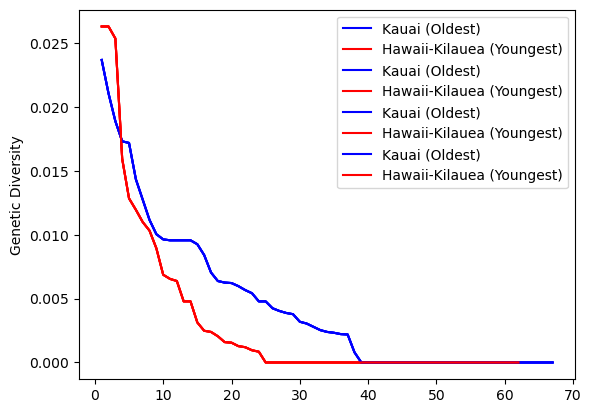

In [17]:
plt.plot(range(1, len(kau_pi)+1), kau_pi, label="Kauai (Oldest)", color='blue')
plt.plot(range(1, len(kil_pi)+1), kil_pi, label="Hawaii-Kilauea (Youngest)", color='red')
plt.ylabel("Genetic Diversity")
plt.legend()
plt.show()

## Look at hill numbers

Kauai Hills - [67.0, 30.204278381359895, 25.35761032546039, 22.348378466036085], evenness 0.4508101250949238
Hawaii Hills - [62.0, 15.697861264237652, 12.333834022803526, 10.75490048443253], evenness 0.25319131071351053


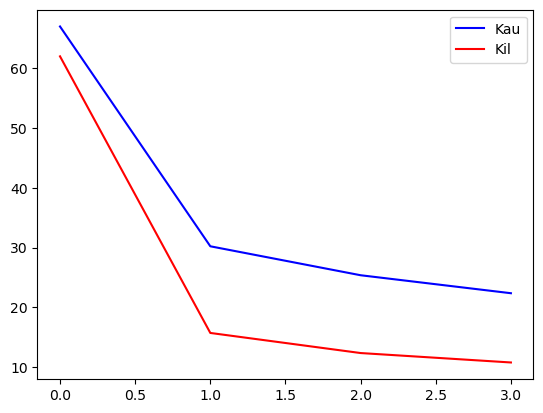

In [22]:
def hill_numbers(dat):
    hvals = []
    for i in range(4):
        hval = iBioGen.util._generalized_hill_number(abunds=dat,
                                                     order=i)
        if i == 1: hval = np.exp(entropy(dat))
        hvals.append(hval)
    return hvals
kau_hill = hill_numbers(kau_pi)
kil_hill = hill_numbers(kil_pi)
plt.plot(range(4), kau_hill, label="Kau", color="blue")
plt.plot(range(4), kil_hill, label="Kil", color="red")
plt.legend()
print(f"Kauai Hills - {kau_hill}, evenness {kau_hill[1]/kau_hill[0]}")
print(f"Hawaii Hills - {kil_hill}, evenness {kil_hill[1]/kil_hill[0]}")
plt.show()

## do all sites intelligently

In [78]:
pis_per_site = {}
for site in set(meta_df["site"]):
    tmp_df = meta_df[meta_df["site"] == site]
    site_sp = tmp_df.groupby("spp")["otu"].apply(list).to_dict()
    pis = []
    for sp in site_sp.keys():
        #import pdb; pdb.set_trace()
        try:
            pi = nucleotide_diversity([otu_dict[x] for x in site_sp[sp]])
            pis.append(pi)
        except:
            print(site, sp)
            raise
    pis_per_site[site] = pis
pis_per_site.keys()

dict_keys(['kokee', 'kamakou', 'waikamoi', 'treePlanting', 'escape', 'thurston', 'flow1973', 'kohalaOld', 'olaa', 'alili', 'kaiholenaYng'])

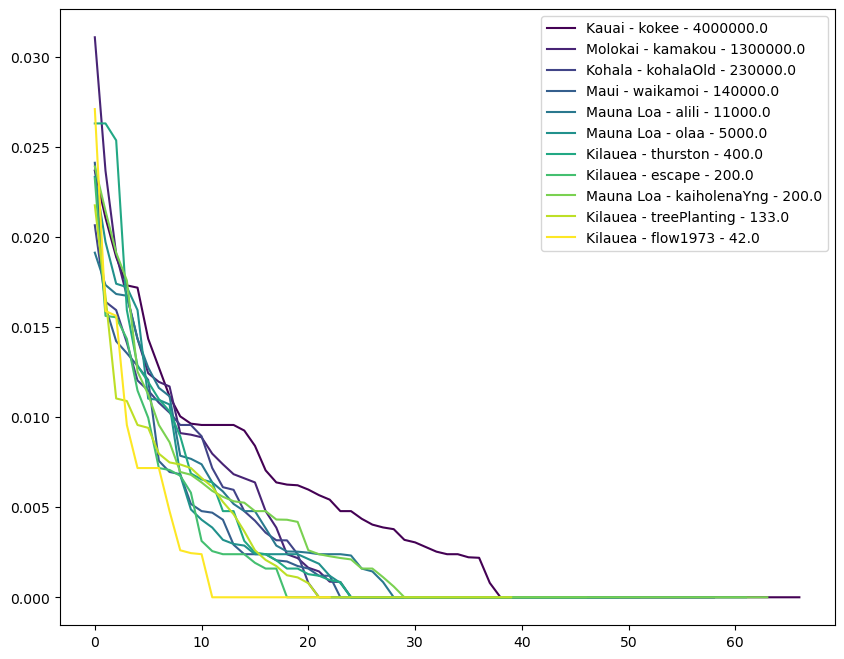

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap('viridis')
ages = [meta_df[meta_df["site"] == x]["flowAgeMin"].iloc[0] for x in pis_per_site.keys()]
site_ages = {x:y for x, y in zip(pis_per_site.keys(), ages)}
# Sort the site dict by age
site_ages = {k: v for k, v in sorted(site_ages.items(), key=lambda x: x[1], reverse=True)}

for site, c in zip(site_ages.keys(), cmap(np.linspace(0, 1, len(pis_per_site)))):
    pis = sorted(pis_per_site[site], reverse=True)
    v = meta_df[meta_df["site"] == site]["volcano"].iloc[0]
    age = meta_df[meta_df["site"] == site]["flowAgeMin"].iloc[0]
    if True: # v != "Kilauea":
        plt.plot(pis, label=f"{v} - " + site + f" - {age}", color=c)
plt.legend()

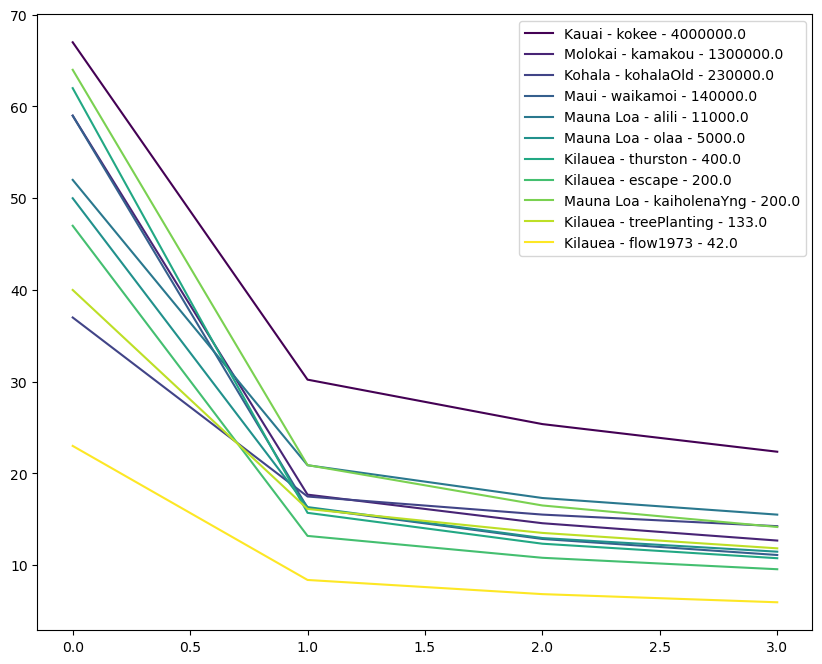

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.get_cmap('viridis')
ages = [meta_df[meta_df["site"] == x]["flowAgeMin"].iloc[0] for x in pis_per_site.keys()]
site_ages = {x:y for x, y in zip(pis_per_site.keys(), ages)}
# Sort the site dict by age
site_ages = {k: v for k, v in sorted(site_ages.items(), key=lambda x: x[1], reverse=True)}

for site, c in zip(site_ages.keys(), cmap(np.linspace(0, 1, len(pis_per_site)))):
    pis = sorted(pis_per_site[site], reverse=True)
    v = meta_df[meta_df["site"] == site]["volcano"].iloc[0]
    age = meta_df[meta_df["site"] == site]["flowAgeMin"].iloc[0]
    if True: #v != "Kilauea":
        plt.plot(hill_numbers(pis), label=f"{v} - " + site + f" - {age}", color=c)
plt.legend()

In [106]:
site_status = {}
for site in set(meta_df["site"]):
    tmp_df = meta_df[meta_df["site"] == site]
    site_sp = tmp_df.groupby("spp")["predict"].apply(set).values
    site_status[site] = Counter([list(x)[0] for x in site_sp])

[f"{x} {site_status[x]}" for x in site_ages.keys()]

["kokee Counter({'endemic': 53, 'introduced': 14})",
 "kamakou Counter({'endemic': 51, 'introduced': 8})",
 "kohalaOld Counter({'endemic': 31, 'introduced': 6})",
 "waikamoi Counter({'endemic': 49, 'introduced': 10})",
 "alili Counter({'endemic': 39, 'introduced': 13})",
 "olaa Counter({'endemic': 38, 'introduced': 12})",
 "thurston Counter({'endemic': 51, 'introduced': 11})",
 "escape Counter({'endemic': 38, 'introduced': 9})",
 "kaiholenaYng Counter({'endemic': 51, 'introduced': 13})",
 "treePlanting Counter({'endemic': 29, 'introduced': 11})",
 "flow1973 Counter({'endemic': 17, 'introduced': 6})"]

## Load iBioGen simulated data

In [72]:
%%time
neutral_simfile = "/home/isaac/iBioGen/empirical_data/default_iBioGen/sim-neutral-ntaxa300-SIMOUT.csv"
comp_simfile = "/home/isaac/iBioGen/empirical_data/default_iBioGen/sim-comp-ntaxa300-SIMOUT.csv"
filt_simfile = "/home/isaac/iBioGen/empirical_data/default_iBioGen/sim-filt-ntaxa300-SIMOUT.csv"

all_sims_params = []
all_sims_locs = []
for model, simfile in zip(["neutral", "competition", "filtering"],
                            [neutral_simfile, comp_simfile, filt_simfile]):
    params_df, loc_df = iBioGen.util.load_local_sims(simfile)
    print(model, len(params_df))
    params_df["assembly_model"] = model
    all_sims_params.append(params_df)
    all_sims_locs.append(loc_df)

all_sims_params_df = pd.concat(all_sims_params, axis=0, ignore_index=True)
all_sims_locs_df = pd.concat(all_sims_locs, axis=0, ignore_index=True)
## Prune out simulations that have low species richness
all_sims_locs_df = all_sims_locs_df[all_sims_params_df["local_S"] < 80]
all_sims_params_df = all_sims_params_df[all_sims_params_df["local_S"] < 80]
all_sims_params_df

neutral 21131
competition 39530
filtering 21129
CPU times: user 12min 26s, sys: 21.5 s, total: 12min 47s
Wall time: 12min 51s


,ClaDS_sigma,ClaDS_alpha,J,colrate,ecological_strength,local_stop_time,meta_obs_ntaxa,meta_obs_time,local_obs_time(gen),local_obs_time(eq),meta_turnover_rate,ClaDS_m,local_S,abund_h1,abund_h2,abund_h3,pi_h1,pi_h2,pi_h3,trait_h1,trait_h2,trait_h3,assembly_model
4,0.173057,0.717267,59054,0.000220,0.137805,0.783220,300,29.864139,12511,0.783774,0.224806,0.728089,66,16.174702,10.460284,8.413836,26.973379,20.279280,17.599668,19.291321,12.722839,10.569858,neutral
7,0.270748,0.600478,43290,0.000229,1.100166,0.730681,300,186.322347,4928,0.731277,0.294118,0.622896,48,8.671855,5.716281,4.923318,21.896966,16.632270,14.163561,10.669372,7.452981,6.301135,neutral
8,0.189075,0.888515,42979,0.000279,2.126178,0.896735,301,15.897077,8154,0.896926,0.511327,0.904539,45,14.244696,8.648942,6.669201,24.407018,19.231632,16.405283,13.553232,9.230057,7.730653,neutral
11,0.169639,0.618577,135813,0.000114,0.300790,0.518268,300,93.099220,7949,0.520414,0.339207,0.627542,74,10.739357,4.074567,3.002143,39.236406,29.931166,25.416602,16.150647,9.593603,8.062039,neutral
19,0.255235,0.605211,71372,0.000139,1.195354,0.766307,300,79.660102,14459,0.768453,0.182561,0.625249,74,21.223762,11.866870,8.391281,33.273252,26.236792,22.881559,19.895812,13.015024,10.732896,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81781,0.231825,0.691273,53049,0.000219,0.356240,0.628498,300,60.203552,21,0.663971,0.250000,0.710100,38,8.937655,5.847371,4.744741,18.046432,13.963778,12.138153,8.363260,6.475235,5.877519,filtering
81782,0.194776,0.698515,108412,0.000157,0.315547,0.829815,300,40.944289,11509,0.830259,0.186992,0.711892,45,2.524231,2.037808,1.836685,7.134116,5.498403,4.882850,4.593920,3.396054,3.227175,filtering
81784,0.258043,0.747706,43654,0.000578,0.105687,0.551845,301,15.953953,590,0.553947,0.310502,0.773019,61,6.969487,3.889059,3.199451,23.995823,17.377207,14.736813,10.865741,5.572723,4.640276,filtering
81785,0.368660,0.600062,147090,0.000179,2.455445,0.941791,300,59.424077,4,0.995479,0.214660,0.642257,44,3.456328,2.904939,2.742221,11.917487,9.367573,8.282917,5.001577,3.503996,3.194863,filtering


## iBioGen model classification raw pi values

In [93]:
# Empirical data must fit the shape of the simulated pis
def zero_pad(pi_array, data):
    len_diff = data.shape[1]-len(pi_array)
    pi_array = np.pad(np.array(pi_array), (0, len_diff), mode="constant")
    return pi_array

pis = all_sims_locs_df.T.apply(lambda y: sorted([x["pi"] for x in y.dropna()], reverse=True))
pis = pd.DataFrame.from_records(pis.values).fillna(0)

y = all_sims_params_df["assembly_model"]
print(len(pis), len(y))


46246 46246


In [99]:
%%time
X = pis

gbc = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
gbc.fit(X, y)

raw_pi_res = {}
for site, pi in {"Kil":kil_pi, "Kau":kau_pi}.items():
    result = gbc.predict_proba(zero_pad(pi, X).reshape(1, -1))
    raw_pi_res[site] = result[0]
raw_pi_res = pd.DataFrame(raw_pi_res, index=gbc.classes_).T
raw_pi_res

,competition,filtering,neutral
Kil,0.008276,0.985331,0.006393
Kau,0.003878,0.852887,0.143235


### iBiogen model classification with scaled pi values

In [105]:
%%time
X = pis.div(np.sum(pis, axis=1), axis=0)

gbc = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
gbc.fit(X, y)

scaled_pi_res = {}
for site, pi in {"Kil":kil_pi, "Kau":kau_pi}.items():
    pi = zero_pad(pi, X)/np.sum(pi)
    result = gbc.predict_proba(pi.reshape(1, -1))
    scaled_pi_res[site] = result[0]
scaled_pi_res = pd.DataFrame(scaled_pi_res, index=gbc.classes_).T
scaled_pi_res


CPU times: user 2min 18s, sys: 296 ms, total: 2min 18s
Wall time: 2min 18s


,competition,filtering,neutral
Kil,0.086615,0.824897,0.088489
Kau,0.917293,0.026051,0.056657


In [183]:
scaled_pi_res.index = ["Hawaii-Kilauea", "Kauai"]
scaled_pi_res

,competition,filtering,neutral
Hawaii-Kilauea,0.086615,0.824897,0.088489
Kauai,0.917293,0.026051,0.056657


### iBioGen model classification with hill numbers

In [104]:
%%time
X = all_sims_params_df[["local_S", "pi_h1", "pi_h2", "pi_h3"]]

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(X, y)

raw_hill_res = {}
for site, hills in {"Kil":kil_hill, "Kau":kau_hill}.items():
    result = gbc.predict_proba(np.array(hills).reshape(1, -1))
    raw_hill_res[site] = result[0]
raw_hill_res = pd.DataFrame(raw_hill_res, index=gbc.classes_).T
raw_hill_res

CPU times: user 1min 36s, sys: 152 ms, total: 1min 37s
Wall time: 1min 37s


,competition,filtering,neutral
Kil,0.00420,0.993691,0.002108
Kau,0.59905,0.222188,0.178762


### iBioGen parameter estimation raw pi values

In [150]:
targets = ["J", "local_obs_time(gen)", "local_obs_time(eq)", "colrate"]

X = pis
y = all_sims_params_df[targets]
print(len(X), len(y))

46246 46246


In [ ]:
%%time
gb_hill_preds = pd.DataFrame([], columns=targets, index=["Kil", "Kau"])
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
    gb_rgr.fit(X, y[t])

    for site, pi in {"Kil":kil_pi, "Kau":kau_pi}.items():
        empirical_pis = zero_pad(pi, X).reshape(1, -1)
        pred = gb_rgr.predict(empirical_pis)
        gb_hill_preds[t][site] = pred[0]
gb_hill_preds

J
local_obs_time(gen)
local_obs_time(eq)
colrate
ClaDS_alpha


### iBioGen parameter estimation with scaled pi values

In [153]:
%%time
X = pis.div(np.sum(pis, axis=1), axis=0)
gb_hill_preds = pd.DataFrame([], columns=targets, index=["Kil", "Kau"])
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
    gb_rgr.fit(X, y[t])

    for site, pi in {"Kil":kil_pi, "Kau":kau_pi}.items():
        empirical_pis = zero_pad(pi, X)/np.sum(pi)
        pred = gb_rgr.predict(empirical_pis.reshape(1, -1))
        gb_hill_preds[t][site] = pred[0]
gb_hill_preds

J
local_obs_time(gen)
local_obs_time(eq)
colrate
CPU times: user 24min 54s, sys: 2.73 s, total: 24min 57s
Wall time: 24min 57s


,J,local_obs_time(gen),local_obs_time(eq),colrate
Kil,72809.142357,2099.675076,0.762704,0.000424
Kau,68990.122091,1654.02619,0.965619,0.001837


### iBioGen parameter estimation hill numbers

In [152]:
X = all_sims_params_df[["local_S", "pi_h1", "pi_h2", "pi_h3"]]

gb_hill_preds = pd.DataFrame([], columns=targets, index=["Kil", "Kau"])
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
    gb_rgr.fit(X, y[t])

    for site, hills in {"Kil":kil_hill, "Kau":kau_hill}.items():
        empirical_pis = np.array(hills).reshape(1, -1)
        pred = gb_rgr.predict(empirical_pis)
        gb_hill_preds[t][site] = pred[0]
gb_hill_preds

J
local_obs_time(gen)
local_obs_time(eq)
colrate


,J,local_obs_time(gen),local_obs_time(eq),colrate
Kil,88057.962638,2393.856323,0.7637,0.000812
Kau,78890.230567,2028.340666,0.886624,0.000999


## Load MESS Simulated data

In [125]:
#mess_sims = pd.read_csv("/home/isaac/lab-notebooks/bii/spider_data/MESS_sims/fig5-SIMOUT.txt", sep="\t")
mess_sims = pd.read_csv("/home/isaac/lab-notebooks/bii/spider_data/MESS_sims/SIMOUT.txt", sep="\t")
#mess_sims = mess_sims[(mess_sims["S"] > 50) & (mess_sims["S"] < 75)]
mess_sims

,S_m,J_m,speciation_rate,death_proportion,trait_rate_meta,ecological_strength,generations,community_assembly_model,speciation_model,mutation_rate,alpha,sequence_length,J,m,speciation_prob,generation,_lambda,migrate_calculated,extrate_calculated,trait_rate_local,filtering_optimum,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,trait_h1,trait_h2,trait_h3,trait_h4,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,abundance_dxy_cor,abundance_pi_cor,abundance_trait_cor,dxy_pi_cor,dxy_trait_cor,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,250,500000,2.0,0.7,2.0,0.01490,0.0,neutral,point_mutation,0.0,5925,570.0,1145.0,0.00275,0.00210,44.0,0.14061,0.00264,0.00284,0.58824,2.61654,18.0,1.95015,1.32432,1.23810,1.20913,5.23486,4.77977,4.50305,4.32494,0.00040,0.00067,1.45236,0.63033,0.00000,0.00061,0.00390,0.00308,-0.20362,-1.78140,0.00526,0.00658,0.0,9.30256,7.37194,6.91556,6.69134,0.54403,1.99334,0.87302,0.36092,-0.05717,1.90436,0.97133,2.59910,0.32451,0.45836,0.61159,3.16047,0.42730,0.60575,-0.54851,0.09743,0.66877,1.25611,-0.12742,0.56465,0.06945,0.12310,-0.14764,0.07867,12.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0
1,250,500000,2.0,0.7,2.0,0.02989,0.0,competition,point_mutation,0.0,6157,570.0,3148.0,0.00308,0.00288,44.0,0.84784,0.00287,0.00360,0.58824,-3.59273,37.0,5.96201,3.43771,2.78785,2.52333,18.10650,14.74020,12.39057,10.92630,0.00042,0.00051,1.82490,3.67578,0.00035,0.00062,0.00262,0.00136,0.30925,0.10509,0.00263,0.00175,0.0,7.86152,5.17518,4.52041,4.23991,-1.86126,4.34381,0.28630,-1.79738,-5.08790,8.59747,-2.54374,3.47344,0.66031,-0.95209,-4.05035,6.32126,-0.68248,-0.87037,0.37401,0.84529,1.03755,-2.27621,0.13288,0.49616,0.25421,-0.01709,-0.14617,-0.02804,15.0,10.0,3.0,4.0,3.0,0.0,0.0,0.0,1.0,1.0
2,250,500000,2.0,0.7,2.0,0.03518,0.0,competition,point_mutation,0.0,4174,570.0,3046.0,0.00298,0.00055,19.0,0.53940,0.00280,0.00180,0.58824,0.70615,16.0,4.15277,3.22126,2.88896,2.70153,4.42265,4.01636,3.74303,3.55456,0.00023,0.00040,1.61456,1.38245,0.00000,0.00035,0.00157,0.00145,1.22748,1.93829,0.00175,0.00197,0.0,4.94782,3.87740,3.58357,3.44664,4.22024,5.82442,0.03844,-1.69840,3.12436,11.09295,3.99446,3.74995,0.38951,-0.45178,3.30654,5.34000,-0.22578,-2.07447,0.35107,1.24661,0.18217,-5.75294,0.31557,0.35870,0.18639,0.60977,0.00896,0.07884,11.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
3,250,500000,2.0,0.7,2.0,1.61120,0.0,filtering,point_mutation,0.0,1856,570.0,2417.0,0.00171,0.00084,19.0,0.22259,0.00182,0.00219,0.58824,-1.16563,9.0,2.27982,1.60613,1.45323,1.39581,2.88169,2.76555,2.66021,2.57074,0.00015,0.00022,1.08813,-0.31374,0.00000,0.00035,0.00441,0.00181,-1.54084,0.68981,0.00526,0.00000,0.0,5.26884,4.40070,4.15648,4.05476,-1.22131,0.13271,-0.42337,-1.39262,-1.15430,0.20411,-1.98068,2.34050,0.17665,0.10075,-1.87342,2.89793,-0.75936,2.20779,0.60002,1.49337,-0.71912,2.69382,-0.38341,-0.18924,-0.13333,0.39279,-0.07303,0.15936,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
4,250,500000,2.0,0.7,2.0,0.69764,0.0,filtering,point_mutation,0.0,1484,570.0,3144.0,0.00275,0.00060,168.0,0.95102,0.00257,0.00171,0.58824,-7.31004,19.0,2.03360,1.39355,1.28983,1.25408,4.29857,3.01254,2.51713,2.30082,0.00048,0.00111,3.27640,10.14002,0.00000,0.00035,0.00735,0.00581,0.83288,0.14414,0.00719,0.00518,0.0,7.45692,5.56896,5.24664,5.13201,-2.51978,3.41977,0.00320,-1.33660,-2.32049,6.41394,-1.24319,3.31560,-0.24458,-0.78489,-1.48882,5.69909,1.27659,-0.10417,-0.24779,0.55171,0.83167,-0.71485,0.49935,0.17382,0.25311,0.57251,0.26022,-0.31002,15.0,2.0,1.0,0.0,0.0,0.0,0.0,0

## MESS assembly model classification hill numbers

In [160]:
%%time
mess_y = mess_sims["community_assembly_model"]
mess_X = mess_sims[["S", "pi_h1", "pi_h2", "pi_h3"]]

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(mess_X, mess_y)

mess_raw_hill_res = {}
for site, hills in {"Kil":kil_hill, "Kau":kau_hill}.items():
    result = gbc.predict_proba(np.array(hills).reshape(1, -1))
    mess_raw_hill_res[site] = result[0]
mess_raw_hill_res = pd.DataFrame(mess_raw_hill_res, index=gbc.classes_).T
mess_raw_hill_res

CPU times: user 9.81 s, sys: 28 ms, total: 9.83 s
Wall time: 9.83 s


,competition,filtering,neutral
Kil,0.529494,0.242176,0.228330
Kau,0.316775,0.284912,0.398313


Text(0.5, 1.0, 'Permutation Importances (test set)')

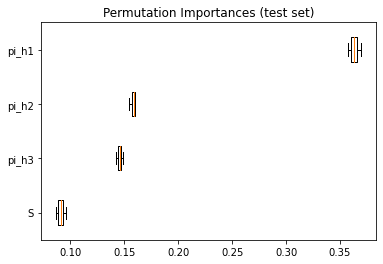

In [127]:
result = permutation_importance(gbc, mess_X, mess_y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=mess_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

## MESS parameter estimation hill numbers

In [157]:
mess_sims = pd.read_csv("/home/isaac/lab-notebooks/bii/spider_data/MESS_sims/fig5-SIMOUT.txt", sep="\t")
#mess_sims = pd.read_csv("/home/isaac/lab-notebooks/bii/spider_data/MESS_sims/SIMOUT.txt", sep="\t")
mess_sims = mess_sims[(mess_sims["S"] > 50) & (mess_sims["S"] < 75)]
mess_sims

,S_m,J_m,speciation_rate,death_proportion,trait_rate_meta,ecological_strength,generations,community_assembly_model,speciation_model,mutation_rate,alpha,sequence_length,J,m,speciation_prob,generation,_lambda,migrate_calculated,extrate_calculated,trait_rate_local,filtering_optimum,S,abund_h1,abund_h2,abund_h3,abund_h4,pi_h1,pi_h2,pi_h3,pi_h4,mean_pi,std_pi,skewness_pi,kurtosis_pi,median_pi,iqr_pi,mean_dxys,std_dxys,skewness_dxys,kurtosis_dxys,median_dxys,iqr_dxys,trees,trait_h1,trait_h2,trait_h3,trait_h4,mean_local_traits,std_local_traits,skewness_local_traits,kurtosis_local_traits,median_local_traits,iqr_local_traits,mean_regional_traits,std_regional_traits,skewness_regional_traits,kurtosis_regional_traits,median_regional_traits,iqr_regional_traits,reg_loc_mean_trait_dif,reg_loc_std_trait_dif,reg_loc_skewness_trait_dif,reg_loc_kurtosis_trait_dif,reg_loc_median_trait_dif,reg_loc_iqr_trait_dif,abundance_dxy_cor,abundance_pi_cor,abundance_trait_cor,dxy_pi_cor,dxy_trait_cor,pi_trait_cor,SGD_0,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9
0,250,500000,2.0,0.7,2.0,0.02676,0.0,neutral,point_mutation,0.0,3041,570.0,2942.0,0.00155,0.00287,966.0,0.94086,0.00160,0.00375,0.58824,-0.84042,65.0,14.24472,7.30576,5.52449,4.77490,23.29364,17.49563,13.67382,11.41103,0.00060,0.00098,3.00644,12.42661,0.00000,0.00097,0.03804,0.02896,0.06628,-1.56031,0.03211,0.06614,0.0,21.05220,11.54010,8.87926,7.73223,-1.68426,3.00312,1.80240,4.20165,-2.51892,2.56642,-2.65502,3.18041,2.33030,6.04429,-3.83588,1.97522,-0.97076,0.17730,0.52790,1.84264,-1.31696,-0.59121,0.02672,0.35621,0.05547,-0.30198,0.06503,0.04088,41.0,13.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0
9,250,500000,2.0,0.7,2.0,0.00115,0.0,filtering,point_mutation,0.0,1360,570.0,8401.0,0.00161,0.00089,149.0,0.67028,0.00165,0.00146,0.58824,-2.00955,52.0,2.67985,2.05482,1.93813,1.87278,12.31992,11.02295,10.07965,9.38625,0.00018,0.00036,2.01775,3.43160,0.00000,0.00035,0.01766,0.01190,-0.22553,-1.58478,0.02123,0.02263,0.0,3.18720,2.37990,2.29239,2.26335,0.69533,2.56701,-0.65921,-0.56205,1.78241,4.20604,1.72452,2.40244,-1.21191,0.64132,2.71150,3.01777,1.02919,-0.16457,-0.55270,1.20337,0.92910,-1.18827,0.08516,0.39967,0.03414,0.12309,0.38518,0.07105,38.0,0.0,6.0,0.0,2.0,1.0,4.0,0.0,0.0,1.0
11,250,500000,2.0,0.7,2.0,0.00751,0.0,neutral,point_mutation,0.0,9986,570.0,3614.0,0.00232,0.00184,235.0,0.27615,0.00225,0.00296,0.58824,-2.31328,53.0,3.99876,1.80012,1.56311,1.48761,18.61559,13.61540,11.34698,10.18009,0.00113,0.00193,2.46737,5.86814,0.00035,0.00133,0.00892,0.00508,-0.49248,-0.89783,0.01193,0.00842,0.0,20.29810,12.73882,10.87224,9.86452,-3.57556,2.42137,1.14844,0.43588,-4.63433,2.85753,-4.26415,1.93089,1.94617,3.78849,-4.82656,1.14624,-0.68859,-0.49048,0.79773,3.35261,-0.19223,-1.71128,0.17595,0.53494,-0.02059,0.18869,-0.21488,0.11056,34.0,9.0,2.0,4.0,0.0,1.0,0.0,1.0,0.0,2.0
14,250,500000,2.0,0.7,2.0,0.00127,0.0,competition,point_mutation,0.0,9018,570.0,3457.0,0.00221,0.00249,482.0,0.82817,0.00216,0.00335,0.58824,0.90447,67.0,18.56266,10.85337,8.64497,7.66205,33.22255,25.67114,21.37170,18.64067,0.00105,0.00134,1.95735,4.63205,0.00062,0.00140,0.02354,0.01442,-0.03167,-1.05255,0.02228,0.02316,0.0,19.35479,11.81750,9.50520,8.42849,1.57066,2.36865,0.25429,-1.05065,1.55552,3.99188,1.66332,1.96396,-0.03584,0.09655,1.62833,1.77125,0.09266,-0.40468,-0.29013,1.14720,0.07281,-2.22063,0.02443,0.34964,0.06955,-0.26281,-0.10562,-0.01186,40.0,11.0,5.0,2.0,6.0,1.0,1.0,0.0,0.0,1.0
15,250,500000,2.0,0.7,2.0,0.17380,0.0,neutral,point_mutation,0.0,6806,570.0,2868.0,0.00699,0.00353,59.0,0.28801,0.00658,0.00526,0.58824,-4.70308,72.0,4.59709,1.85605,1.59705,1.51619,25.23017,21.52819,19.14360,17.48206,0.00047,0.00072,1.70267,2.52052,0.00000,0.00067,0.00574,0.00380,-0.14709,-1.20657,0.00684,0.00667,0.0,18.95055,11.55125,10.24305,9.67518,2.85672,2.35893,-1.04984,0.03486,3.80528,3.10936,2.81091,2.42397,-1.26765,1.11247,3.71340,2.80781,-0.04581,0.06505,-0.21781,1.07761,-0.09188,-0.30156,0.01753,0.49774,0.03900,0.12653,-0.21108,0.05208

In [158]:
targets = ["J", "m", "speciation_prob", "generation", "_lambda", "ecological_strength"]
mess_params_y = mess_sims[targets]
mess_params_X = mess_sims[["S", "pi_h1", "pi_h2", "pi_h3"]]


In [141]:
%%time
rf_rgr = RandomForestRegressor(max_depth=5, random_state=0, n_jobs=-1, n_estimators=500)
rf_rgr.fit(mess_params_X, mess_params_y)

rf_preds = pd.DataFrame([], columns=targets, index=["Kil", "Kau"])
for site, hills in {"Kil":kil_hill, "Kau":kau_hill}.items():
    pred = rf_rgr.predict(np.array(hills).reshape(1, -1))
    rf_preds.loc[site] = pred
rf_preds

CPU times: user 4.95 s, sys: 512 ms, total: 5.46 s
Wall time: 1.89 s


,J,m,speciation_prob,generation,_lambda,ecological_strength
Kil,3716.51423,0.004457,0.0031,159.216985,0.50315,1.299201
Kau,3892.275777,0.005058,0.002085,332.396332,0.617518,1.328144


In [159]:
%%time
gb_hill_preds = pd.DataFrame([], columns=targets, index=["Kil", "Kau"])
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
    gb_rgr.fit(mess_params_X, mess_params_y[t])

    for site, hills in {"Kil":kil_hill, "Kau":kau_hill}.items():
        empirical_pis = np.array(hills).reshape(1, -1)
        pred = gb_rgr.predict(empirical_pis)
        gb_hill_preds[t][site] = pred[0]
gb_hill_preds

J
m
speciation_prob
generation
_lambda
ecological_strength
CPU times: user 24.1 s, sys: 15.9 ms, total: 24.2 s
Wall time: 24.2 s


,J,m,speciation_prob,generation,_lambda,ecological_strength
Kil,5216.992963,0.004427,0.00274,105.646729,0.419549,0.081322
Kau,5708.81971,0.004093,0.002085,202.4543,0.465861,0.259336
